# NN from scratch
This notebook is for purely understanding the process and calculation of NN. I have taken reference from Samson Zhang's, 3blue1brown videos for this notebook. Also if you do want to learn how NN works check out [3blue1brown's video series](https://youtu.be/aircAruvnKk).

I have linked my github repositry where I uploaded my calculation for the whole model. Certain bits of code had to be fixed from Samson's video and I'll mention it below.

[Setting up the nodes and functions](https://github.com/ENGSSG/NN-from-scratch/blob/main/NN%20setup.jpeg)

[How to differentiate softmax function](https://github.com/ENGSSG/NN-from-scratch/blob/main/Softmax%20differentiation.jpeg)


**Things to keep in mind for this NN**
* This was a project that was written on Kaggle, so the files are [here](https://www.kaggle.com/competitions/digit-recognizer/data). I wanted to store it directly to the repositry, but it was too large.
* For cost(or loss) function, categorical cross entropy equation was used, which is y*ln(a2). As this is a categorical problem and it makes the equation much simpler.
* Softmax function has been changed to prevent overflowing.
* The sum function used for b1 & b2 in Samson's video does not actually reflect the model. (He summed all the values in the array. Where you should only add it accross column.)
* Placed Onehotencode outside of the loop as it is not necessary and causes extra calculation.
* If anyone wants to see how derivation works for softmax and differentiation of a to z, please check out the blog from [Thomas Kurbiel](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import os

## Prepare Data

In [7]:
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
data=np.array(data)
test=np.array(test_data)
test=test/255
m, n = data.shape
np.random.shuffle(data)

In [9]:
x_train=data[0:m,1:785]
y_train=data[0:m,0]
x_train=x_train/255
_,m_train = x_train.shape

## Functions for gradient descent

In [10]:
def init_param(): # Initialize parameters
    w1=(np.random.rand(784,20)-0.5)*0.001
    b1=(np.random.rand(1,20)-0.5)*0.001
    w2=(np.random.rand(20,10)-0.5)*0.001
    b2=(np.random.rand(1,10)-0.5)*0.001
    
    return w1, b1, w2, b2

def ReLU(z): # ReLU function
    return np.maximum(z,0)

def Softmax(z): # Softmax function
    t,b=np.shape(z)
    exp = np.exp(z - np.max(z))
    return exp / np.reshape(exp.sum(axis=1),(t,1))

def f_propagation(a0,w1,b1,w2,b2): # Forward propagation makes prediction using the parameters(w1,b1,w2,b2)

    z1 = a0.dot(w1)+b1  # m x 20
    a1 = ReLU(z1)       # m x 20
    z2 = a1.dot(w2)+b2  # m x 10
    a2 = Softmax(z2)    # m x 10 

    return z1, a1, z2, a2

def dev_ReLU(z):
    return z>0

def one_hotencode(y): # Need to onehot encode the numbers as the way this NN is set up it cannot understand normal integers
    y_hat=np.zeros((np.size(y),10))
    y_hat[np.arange(y.size),y] = 1
    return y_hat

def b_propagation(x,z1,w1,a1,z2,w2,a2): # Calculates the error between the prediction & the actual results. Then Calculate the nudge for each parameters. 
    dadc = (a2 - y_hat)                                        # m x 10 
    dw2 = 1/m * (a1.T.dot(dadc))                               # 20 x 10
    db2 = 1/m * np.sum(dadc,axis=0)                            # 1 x 10
    dw1 = 1/m * x.T.dot(dadc.dot(w2.T) * dev_ReLU(z1))         # 784 x 20
    db1 = 1/m * np.sum((dadc.dot(w2.T) * dev_ReLU(z1)),axis=0) # 1 x 20
    return dw2, db2, dw1, db1

def update_param(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * np.reshape(db1, (1,20))
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * np.reshape(db2, (1,10))
    return w1, b1, w2, b2

## Gradient descent with accuracy functions

In [11]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(x, y, alpha=0.01, iterations=500):
    w1, b1, w2, b2 = init_param()
    for i in range(iterations):
        z1, a1, z2, a2 = f_propagation(x,w1,b1,w2,b2)
        dw2, db2, dw1, db1 = b_propagation(x,z1,w1,a1,z2,w2,a2)
        w1, b1, w2, b2 = update_param(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 50 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(a2.T)
            print(get_accuracy(predictions, y))
        
    return w1, b1, w2, b2

## Output

In [15]:
y_hat=one_hotencode(y_train)
w1, b1, w2, b2 = gradient_descent(x_train, y_train, 0.1, 750)

Iteration:  0
[9 9 9 ... 9 9 9] [2 2 1 ... 2 5 7]
0.09971428571428571
Iteration:  50
[1 1 1 ... 1 1 1] [2 2 1 ... 2 5 7]
0.11152380952380953
Iteration:  100
[1 1 1 ... 1 1 1] [2 2 1 ... 2 5 7]
0.11152380952380953
Iteration:  150
[0 0 1 ... 0 0 0] [2 2 1 ... 2 5 7]
0.2838095238095238
Iteration:  200
[6 6 1 ... 8 0 7] [2 2 1 ... 2 5 7]
0.6597380952380952
Iteration:  250
[2 6 1 ... 8 5 7] [2 2 1 ... 2 5 7]
0.7535952380952381
Iteration:  300
[2 0 1 ... 8 5 7] [2 2 1 ... 2 5 7]
0.8088333333333333
Iteration:  350
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.8425238095238096
Iteration:  400
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.859452380952381
Iteration:  450
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.871452380952381
Iteration:  500
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.8798809523809524
Iteration:  550
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.8849047619047619
Iteration:  600
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.889452380952381
Iteration:  650
[2 2 1 ... 2 5 7] [2 2 1 ... 2 5 7]
0.8928571428571429
Iteration

## Predictions

In [14]:
def make_predictions(a0, w1, b1, w2, b2):
    _, _, _, a2 = f_propagation(a0,w1,b1,w2,b2)
    predictions = get_predictions(a2.T)
    return predictions

In [22]:
submission_data = make_predictions(test, w1, b1, w2, b2)

## Submission Data

In [ ]:
submission_label = {'ImageId': range(1,28001), 'Label': submission_data}
submission_NN = pd.DataFrame(data=submission_label)
submission_NN.to_csv('MNIST_submission_data.csv', index=False)

## Visual presentation

In [34]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = x_train[index, :]
    prediction = make_predictions(x_train[index, :], w1, b1, w2, b2)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


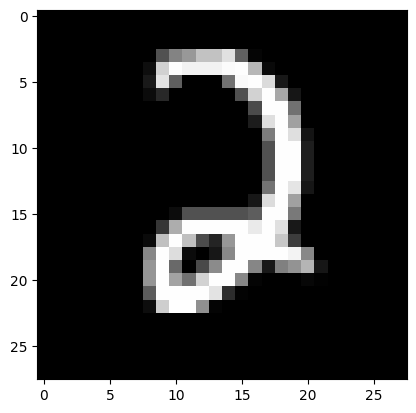

Prediction:  [2]
Label:  2


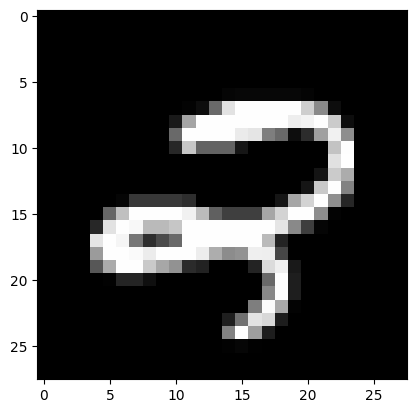

Prediction:  [1]
Label:  1


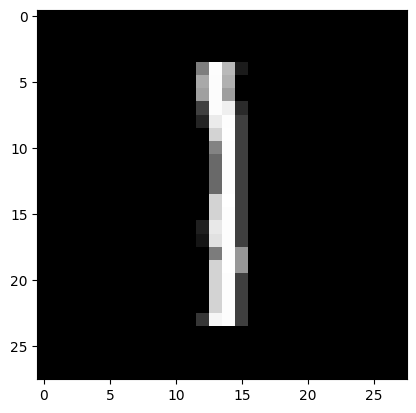

Prediction:  [7]
Label:  7


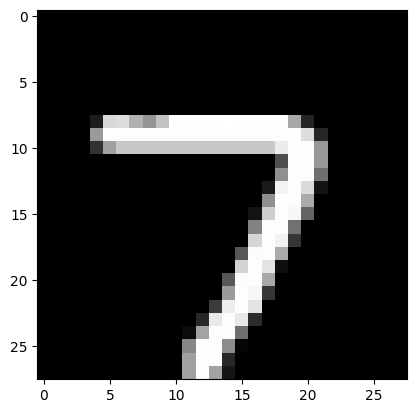

In [35]:
test_prediction(0, w1, b1, w2, b2)
test_prediction(1, w1, b1, w2, b2)
test_prediction(3, w1, b1, w2, b2)
test_prediction(4, w1, b1, w2, b2)

The model worked surprisingly well. :)